# Neural Networks
---

This notebook will implement a neural net from scratch. Available options will include:

* Different hidden and final activation methods. 
    * Currently supports: tanh (default), relu, sigmoid, linear, ~~softmax~~.
    * *Note: softmax doesn't work. Would need to rework to allow for activation gradients to include more than 1 z.*
    
* Different cost functions.
    * Currently supports MSE only.
    
* max_iter (1000): stop the fit after max_iter epochs (NOT steps of gradient descent).

* convergence (1e-5): stop the fit if the loss function falls below a certain threshold.

* batch_size (1): number of examples that are fit simultaneously. Stochastic is default.

* learning_rate (0.1) and gamma (0.9): hyperparameters for gradient descent (with momentum).

---

A neural network consists of multiple layers of neurons, each layer connected to the previous via a matrix of weights. We label each layer as $a^{(k)}$, where $a^{(0)}$ is simply our input data, X. Note that X may be a single row, or multiple examples, with each row corresponding to an example. 


To implement the neural network, we first do a **forward propagation** step to determine the predictions of the network. Each layer is related to the layer before via:

$ z^{(k+1)} = \tilde{a}^{(k)} w^{(k)} $

$ a^{(k+1)} = \phi^{(k+1)} (z^{(k+1)}) $

Where $\phi^{(k)}$ corresponds to the activation function for layer k, and $\tilde{a}$ is the $a$ matrix augmented with a column of ones to allow for the inclusion of a bias (thus, the first row of w will always be the bias vector for the next layer).  

To do gradient descent, we need to determine the derivatives of the cost function, J, with respect to all of the weight matrices, w. We do this via **back propagation** of errors. Consider an arbitrary derivative:

$ \frac{\partial J}{\partial w^{(k)}_{ij}} = \frac{\partial J}{\partial z^{(k+1)}_{kl}} \frac{\partial z^{(k+1)}_{kl}}{\partial w^{(k)}_{ij}} $

We define $\frac{\partial J}{\partial z^{(k)}_{kl}} \equiv \delta^{(k)}_{kl} $ 
and note $\frac{\partial z^{(k+1)}_{kl}}{\partial w^{(k)}_{ij}} = \tilde{a}^{(k)}_{kj} \delta^i_m$

We arrive at

$ \frac{\partial J}{\partial w^{(k)}_{ij}} = \left(\tilde{a}^{(k)T} \delta^{(k+1)}\right)_{ij}$

So we just need to calculate the errors, $\delta^{(k)}_{ij}$. To do this, we see:

$ \delta^{(k)}_{ij} = \frac{\partial J}{\partial z^{(k)}_{ij}} = 
\frac{\partial J}{\partial z^{(k+1)}_{kl}}\frac{\partial z^{(k+1)}_{kl}}{\partial z^{(k)}_{ij}} $

The first part is simply the previous $\delta^{(k+1)}$, i.e.

$\delta_{ij}^{(k+1)} = \frac{\partial J}{\partial z^{(k)}_{ij}}$

While the second part is slightly more complicated. 

$ \frac{\partial z^{(k+1)}_{kl}}{\partial z^{(k)}_{ij}} 
= 
\frac{\partial z^{(k+1)}_{kl}}{\partial \tilde{a}^{(k)}_{mn}} \frac{\partial \tilde{a}^{(k)}_{mn}}{\partial z^{(k)}_{ij}}
=
\frac{\partial z^{(k+1)}_{kl}}{\partial \tilde{a}^{(k)}_{mn}} \phi'^{(k)} (z^{(k)}_{ij}) 
$

The first portion of this derivative is:

$ \frac{\partial z^{(k+1)}_{kl}}{\partial \tilde{a}^{(k)}_{mn}} = \delta^i_k w^{(k)}_{jl} $

Putting this all together, we find that we can write a layers error term in terms of the layer above:

$ \delta^{(k)} = \left(\delta^{(k+1)} \tilde{w}^{(k)T} \right) \cdot * ~\phi'^{(k)} (z^{(k)}) $

Where $ \cdot *$ indicates that we do element-wise multiplication. Also note that here, we use $\tilde{w}$ which is w without the first row, as the bias layer does not get propagated backwards to the previous layer. 

To **summarize**, the final back propagation steps are:

$
\frac{\partial J}{\partial w^{(k)}} = \tilde{a}^{(k)T} \delta^{(k+1)}
$

$ 
\delta^{(k)} = \left(\delta^{(k+1)} \tilde{w}^{(k)T} \right) \cdot * ~\phi'^{(k)} (z^{(k)}) 
$ 

$
\delta^{(L)} = \frac{\partial J}{\partial a^{(L)}} \cdot * ~\phi'^{(L)} (z^{(L)}) 
$

Where the last equation here shows the initial error for the final layer. 


The **gradient descent update** can then be written:

$ w^{(k)} \to w^{(k)} - \alpha \frac{\partial J}{\partial w^{(k)}} $

If we do stochastic gradient descent, and shuffle the order of the examples each epoch, we can help to smooth out overfitting to the training data. 

We can also do [gradient descent with momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d), in which a simplistic momentum addition can be done:

$ v^{(k)}_t = \gamma v^{(k)}_{t-1} + \alpha \frac{\partial J}{\partial w^{(k)}} $

$ w^{(k)}_{t+1} = w^{(k)}_t - v^{(k)}_t $

This helps us to wiggle out of local minima, and possibly move closer to a global minima / smooth out overfitting. 

In [1]:
# Standard
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import matplotlib

In [2]:
class NeuralNetwork:
    
    def __init__(self, layer_sizes, 
                 hidden_activation = 'tanh', final_activation = 'tanh', 
                 cost = 'mse', 
                 learning_rate = 0.1, gamma = 0.9,
                 max_iter = 1000, batch_size = 1, convergence = 1e-5):
        self.layer_sizes = layer_sizes
        self.n_hidden = len(layer_sizes)-2
        self.hidden_activation = hidden_activation
        self.final_activation = final_activation
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.cost = cost
        self.batch_size = batch_size
        self.convergence = convergence
        self.fit_loss = []
        self.gamma = gamma
        self.weights = {}
        self.previous_v = {}
        
        # initialize weights matrices and 'previous velocities' for momentum
        # note that for a NN, the weights must NOT be initialized as 0, need to break the symmetry
        for ii in range(self.n_hidden+1):
            self.weights[ii] = (np.random.rand(self.layer_sizes[ii]+1,self.layer_sizes[ii+1])-0.5)/0.5
            self.previous_v[ii] = 0
            
        # allow for different activations on the hidden and final layers
        if self.hidden_activation == 'tanh':
            self.hidden_activate = self.tanh
            self.hidden_activate_grad = self.tanh_grad
        elif self.hidden_activation == 'relu':
            self.hidden_activate = self.relu
            self.hidden_activate_grad = self.relu_grad
        elif self.hidden_activation == 'sigmoid':
            self.hidden_activate = self.sigmoid
            self.hidden_activate_grad = self.sigmoid_grad
        elif self.hidden_activation == 'linear':
            self.hidden_activate = self.linear
            self.hidden_activate_grad = self.linear_grad
        elif self.hidden_activation == 'softmax':
            self.hidden_activate = self.soft_max
            self.hidden_activate_grad = self.soft_max_grad
            
        if self.final_activation == 'tanh':
            self.final_activate = self.tanh
            self.final_activate_grad = self.tanh_grad
        elif self.final_activation == 'relu':
            self.final_activate = self.relu
            self.final_activate_grad = self.relu_grad 
        elif self.final_activation == 'sigmoid':
            self.final_activate = self.sigmoid
            self.final_activate_grad = self.sigmoid_grad
        elif self.final_activation == 'linear':
            self.final_activate = self.linear
            self.final_activate_grad = self.linear_grad
        elif self.final_activation == 'softmax':
            self.final_activate = self.soft_max
            self.final_activate_grad = self.soft_max_grad
            
            
        # choose appropriate cost function
        if self.cost == 'mse':
            self.loss = self.mse_loss
            self.grad_loss = self.mse_grad
    
    # possible activation functions and their derivatives
    def tanh(self,x):
        return np.tanh(x)
    
    def tanh_grad(self,x):
        return 1 - np.tanh(x)*np.tanh(x)
    
    def relu(self,x):
        return x * (x > 0)
    
    def relu_grad(self,x):
        return 1. * (x > 0)
    
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def soft_max(self,x):
        exp_x = np.exp(x)
        soft_sums = np.sum(exp_x,axis=1,keepdims=True)
        return exp_x/soft_sums
    
    def soft_max_grad(self,x):
        return self.soft_max(x)*(1-self.soft_max(x))
    
    def linear(self,x):
        return x
    
    def linear_grad(self,x):
        return np.ones(x.shape)
    
    # possible cost functions and their derivatives
    def mse_loss(self,x,y):
        y_out = self.predict(x)
        y_sum = np.sum((y-y_out)**2,axis=1,keepdims=True)
        mse = (1/2)*np.mean(y_sum)
        return mse
    
    def mse_grad(self,y,y_out):
        n_examples = x.shape[0]
        return (y_out - y)/n_examples
    
    # do a forward pass
    def predict(self,x):
        a = x
        n_examples = x.shape[0]
        for ii in range(self.n_hidden):
            weight = self.weights[ii]
            a_tilde = np.c_[np.ones(n_examples),a]
            z =  a_tilde @ weight
            a = self.hidden_activate(z)
        weight = self.weights[self.n_hidden]
        a_tilde = np.c_[np.ones(n_examples),a]
        z =  a_tilde @ weight
        a = self.final_activate(z)
        return a
    
    # fit, logging the errors after each epoch
    def fit(self,x,y):
        n_examples = x.shape[0]
        n_examples_list = np.arange(n_examples)
        np.random.shuffle(n_examples_list)
        n_batches = int(np.ceil(n_examples/self.batch_size))
        
        for ii in range(self.max_iter):
            for jj in range(n_batches):
                if jj<(n_batches-1):
                    n_batch_list = n_examples_list[jj:jj+self.batch_size]
                else:
                    n_batch_list = n_examples_list[jj:]
                x_batch = x[n_batch_list,:]
                y_batch = y[n_batch_list,:]
                
                self.backprop(x_batch,y_batch)
                
            loss = self.loss(x,y)
            self.fit_loss.append(loss)
            if loss<self.convergence:
                break
            
            np.random.shuffle(n_examples_list)
                
    # do a backwards pass, updating the weights
    def backprop(self,x,y):  
        n_examples = x.shape[0]
        # feedforward
        # store all a's, z's in a dictionary for later error propagation
        a_dict = {}
        a_dict[0] = x
        z_dict = {}
        z_dict[0] = x
        
        for kk in range(self.n_hidden):
            a_k = np.copy(a_dict[kk])
            a_k_tilde = np.c_[np.ones(n_examples),a_k]
            weight_k = self.weights[kk]
            z_k_plus_one = a_k_tilde @ weight_k
            a_k_plus_one = self.hidden_activate(z_k_plus_one)
            a_dict[kk+1] = np.copy(a_k_plus_one)
            z_dict[kk+1] = np.copy(z_k_plus_one)
         
        # final layer: allow for different activation
        kk = self.n_hidden
        a_k = np.copy(a_dict[kk])
        a_k_tilde = np.c_[np.ones(n_examples),a_k]
        weight_k = self.weights[kk]
        z_k_plus_one = a_k_tilde @ weight_k
        a_k_plus_one = self.final_activate(z_k_plus_one)
        a_dict[kk+1] = np.copy(a_k_plus_one)
        z_dict[kk+1] = np.copy(z_k_plus_one)
        
        # determine backprop errors and update weights
        delta_dict = {}
        y_out = a_k_plus_one
        delta_final = self.grad_loss(y,y_out)*self.final_activate_grad(z_k_plus_one)
        delta_dict[self.n_hidden+1] = delta_final
        
        for kk in range(self.n_hidden,-1,-1):
            delta_k_plus_one = delta_dict[kk+1]
            a_k = a_dict[kk]
            a_k_tilde = np.c_[np.ones(n_examples),a_k]
            weight = self.weights[kk]
            weight_tilde = weight[1:,:]
            z_k = z_dict[kk]
            delta_dict[kk] = (delta_k_plus_one @ weight_tilde.T)*self.hidden_activate_grad(z_k)
            
            # update weight according to gradient of J, using momentum
            grad_wk = a_k_tilde.T @ delta_k_plus_one
            self.previous_v[kk] = self.gamma*self.previous_v[kk] + self.learning_rate*grad_wk
            self.weights[kk] = self.weights[kk] - self.previous_v[kk]
            


## Example: XOR Function
---

This is a classic non-linear function, that a simple neural network should be able to easily solve where a linear solver cannot.

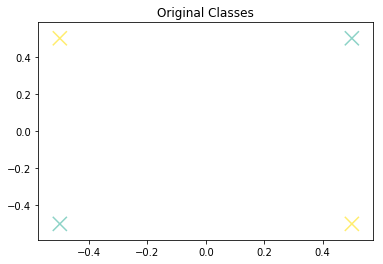

In [3]:
# Data from class (XOR Function)
x = np.array([[-0.5,-0.5],
              [0.5,-0.5],
              [-0.5,0.5],
              [0.5,0.5]])

y = np.array([[-0.5],[0.5],[0.5],[-0.5]])

plt.scatter(x[:,0],x[:,1],c=y.ravel(),marker='x',s=200,cmap=plt.cm.Set3)
plt.title('Original Classes')
plt.show()

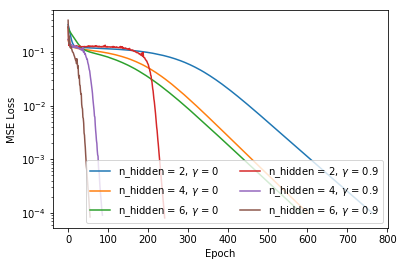

array([[-0.48592   ],
       [ 0.48618119],
       [ 0.48727822],
       [-0.48896774]])

In [5]:
# Fit Neural Net
convergence = 1e-4
learning_rate = 0.1
hidden_list = [2,4,6]
max_iter = 1000
batch_size = 1
hidden_activation = 'tanh'
final_activation = 'tanh'

# Do over a variety of hidden layers and gamma parameters
for hidden in hidden_list:
    test = NeuralNetwork([2,hidden,1],learning_rate = learning_rate, gamma = 0,
                         max_iter = max_iter,convergence = convergence,
                         hidden_activation = hidden_activation, final_activation = final_activation,
                         batch_size=batch_size)
    test.fit(x,y)
    loss_list = test.fit_loss
    plt.plot(loss_list,label='n_hidden = {:d}, $\gamma$ = 0'.format(hidden))

for hidden in hidden_list:
    test = NeuralNetwork([2,hidden,1],learning_rate = learning_rate, gamma = 0.9,
                         max_iter = max_iter,convergence = convergence,
                         hidden_activation = hidden_activation, final_activation = final_activation,
                         batch_size=batch_size)
    test.fit(x,y)
    loss_list = test.fit_loss
    plt.plot(loss_list,label='n_hidden = {:d}, $\gamma$ = 0.9'.format(hidden)) 
    
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.legend(loc='lower right',ncol=2)
plt.yscale('log')
plt.show()

test.predict(x)

## Discussion
---

We see that adding more neurons to the hidden layer typically causes the solution to converge faster, but adding in momentum has a much stronger effect, moving the fitted solution much closer to a global minimum in fewer epochs.

## Cool Plots and Other Examples!
---

In [469]:
x_new = np.arange(-0.6,0.7,0.01)
n_x = x_new.shape[0]
xx,yy = np.meshgrid(x_new,x_new)

x_test = np.empty((n_x**2,2))
for ii,x1 in enumerate(x_new):
    for jj,x2 in enumerate(x_new):
        x_test[ii*n_x+jj,0] = x1
        x_test[ii*n_x+jj,1] = x2
y_test = test.predict(x_test)
y_test = y_test.reshape(n_x,n_x)

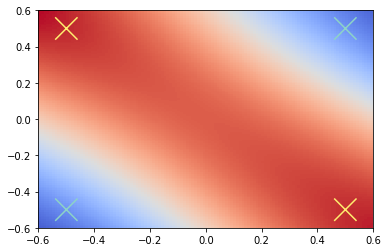

In [470]:
plt.pcolormesh(xx,yy,y_test,cmap = 'coolwarm')
plt.scatter(x[:,0], x[:,1], c = y.ravel(),s = 500,marker = 'x',vmin = -0.5, vmax = 0.5,cmap=plt.cm.Set3)
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
plt.show()

## Example: Moons
---

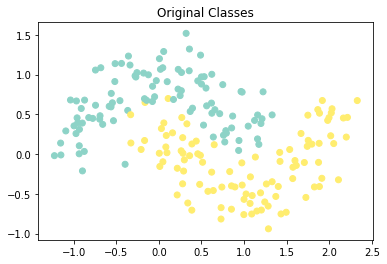

(200, 2)

In [489]:
# Random data sets
from sklearn.datasets import make_blobs, make_moons, make_circles

n_data = 200
x,y = make_moons(n_data, noise=.2)

#fig1,ax1 = plt.subplots(3,2,figsize=(10, 10),sharey=True,sharex=True)
#plt.sca(ax1[0,0])
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.Set3)
plt.title('Original Classes')
plt.show()
y_new = np.zeros((y.shape[0],2))
for ii,yy in enumerate(y):
    y_new[ii,yy] = 1

y_new.shape

In [490]:
y = y.reshape(-1,1)
convergence = 1e-4
learning_rate = 0.1
hidden_list = [2,4,6]
max_iter = 500
batch_size = 100
hidden_activation = 'tanh'
final_activation = 'softmax'
test1 = NeuralNetwork([2,50,2],learning_rate = learning_rate, gamma = 0.9,
                         max_iter = max_iter,convergence = convergence,
                         hidden_activation = hidden_activation, final_activation = final_activation,
                         batch_size=batch_size)
test1.fit(x,y_new)
y_out = test1.predict(x)
y_pred = 1.*(y_out>0.5)

In [2]:
x_new1 = np.arange(-1.1,2.2,0.01)
x_new2 = np.arange(-0.7,1.4,0.01)
n_x1 = x_new1.shape[0]
n_x2 = x_new2.shape[0]
xx,yy = np.meshgrid(x_new1,x_new2)

x_test = np.empty((n_x1*n_x2,2))
for ii,x1 in enumerate(x_new1):
    for jj,x2 in enumerate(x_new2):
        x_test[ii*n_x2+jj,0] = x1
        x_test[ii*n_x2+jj,1] = x2
y_test = test1.predict(x_test)
y_test = y_test[:,1]
y_test = y_test.reshape(n_x1,n_x2).T

NameError: name 'np' is not defined

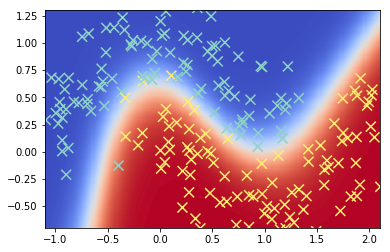

In [492]:
plt.pcolormesh(xx,yy,y_test,cmap = 'coolwarm')
plt.scatter(x[:,0], x[:,1], c = y.ravel(),s = 100,marker = 'x',vmin = 0, vmax = 1,cmap=plt.cm.Set3)
plt.xlim([-1.1,2.1])
plt.ylim([-0.7,1.3])
plt.show()

## Example: Circles
---

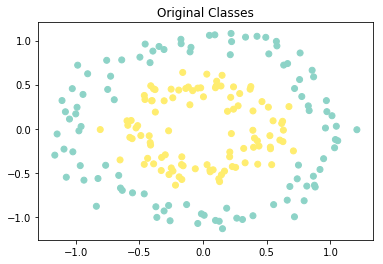

In [452]:
n_data = 200
x,y = make_circles(n_data, noise=0.1, factor=.5)

#fig1,ax1 = plt.subplots(3,2,figsize=(10, 10),sharey=True,sharex=True)
#plt.sca(ax1[0,0])
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.Set3)
plt.title('Original Classes')
plt.show()

In [453]:
y = y.reshape(-1,1)
convergence = 1e-4
learning_rate = 0.1
hidden_list = [2,4,6]
max_iter = 500
batch_size = 100
hidden_activation = 'tanh'
final_activation = 'sigmoid'
test1 = NeuralNetwork([2,50,1],learning_rate = learning_rate, gamma = 0.9,
                         max_iter = max_iter,convergence = convergence,
                         hidden_activation = hidden_activation, final_activation = final_activation,
                         batch_size=batch_size)
test1.fit(x,y)
y_out = test1.predict(x)
y_pred = 1.*(y_out>0.5)

In [454]:
x_new1 = np.arange(-1.1,1.2,0.01)
x_new2 = np.arange(-1.1,1.2,0.01)
n_x1 = x_new1.shape[0]
n_x2 = x_new2.shape[0]
xx,yy = np.meshgrid(x_new1,x_new2)

x_test = np.empty((n_x1*n_x2,2))
for ii,x1 in enumerate(x_new1):
    for jj,x2 in enumerate(x_new2):
        x_test[ii*n_x2+jj,0] = x1
        x_test[ii*n_x2+jj,1] = x2
y_test = test1.predict(x_test)
y_test = y_test.reshape(n_x1,n_x2).T

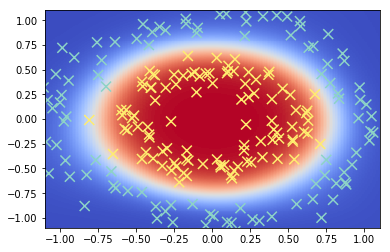

In [455]:
plt.pcolormesh(xx,yy,y_test,cmap = 'coolwarm')
plt.scatter(x[:,0], x[:,1], c = y.ravel(),s = 100,marker = 'x',vmin = 0, vmax = 1,cmap=plt.cm.Set3)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.show()

In [472]:
test = np.array([[1,1],[2,2],[3,3]])
np.sum(test,axis=1,keepdims=True)

array([[2],
       [4],
       [6]])